<a href="https://colab.research.google.com/github/Emilie-Jessen/AppML-Final-Project-2024/blob/main/EfficientNet_V2_only5categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Only 5 classes incl. finetuning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import tensorflow as tf

In [2]:
from tensorflow.keras.applications import EfficientNetV2L, EfficientNetV2B3
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.image import grayscale_to_rgb
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.layers import Lambda, Dense, InputLayer, Rescaling, Dropout, Flatten
from tensorflow.keras import Sequential

In [3]:
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
GPU is NOT AVAILABLE


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [6]:
# The pictures are 48x48 pixels, but the model requires 128x128 pixels

input_pixels = 48
model_pixels = 128
IMAGE_SIZE = (input_pixels, input_pixels)
RE_SIZE = (model_pixels, model_pixels)
BATCH_SIZE = 16

In [18]:
# Load the images from the test folder and create a dataset

def build_trainset(subset):
    return image_dataset_from_directory(
                        f"drive/MyDrive/small_archive/train",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42,
                        validation_split=0.2,
                        subset=subset)

Found 23621 files belonging to 5 classes.
Using 18897 files for training.
Found 23621 files belonging to 5 classes.
Using 4724 files for validation.


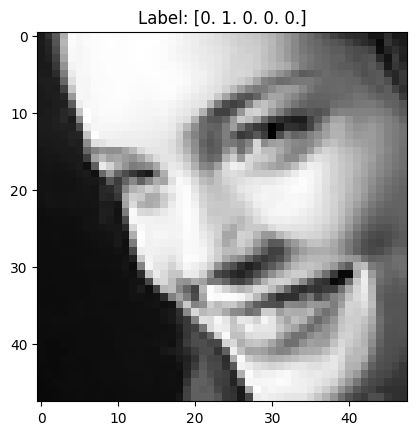

(1, 48, 48, 1)


In [19]:
# Load the training and validation datasets
train_ds = build_trainset("training")
val_ds = build_trainset("validation")

# Get the names of the labels
class_names = tuple(train_ds.class_names)

# Print one image
for image, label in train_ds.take(1):
    plt.imshow(image[0], cmap='gray')
    plt.title(f"Label: {label[0]}")
    plt.show()

# Print the shape of the images
for image, label in train_ds.take(1):
    print(image.shape)

In [20]:
print(class_names)

('angry', 'happy', 'neutral', 'sad', 'surprised')


In [21]:
# Preprocessing of the data

# The pictures are 48x48 pixels, but the model requires 128x128 pixels
resize_layer = Lambda(lambda x: smart_resize(x, size=RE_SIZE))

# The model requires 3 channels, so we need to convert the grayscale image to RGB
grayscale_to_rgb_layer = Lambda(lambda x: grayscale_to_rgb(x))

# Create preprocessing model
preprocessing_model = Sequential()
preprocessing_model.add(resize_layer)
preprocessing_model.add(grayscale_to_rgb_layer)

In [22]:
# Apply the preprocessing model to the training and validation datasets
train_ds = train_ds.map(lambda image, label: (preprocessing_model(image), label))
val_ds = val_ds.map(lambda image, label: (preprocessing_model(image), label))

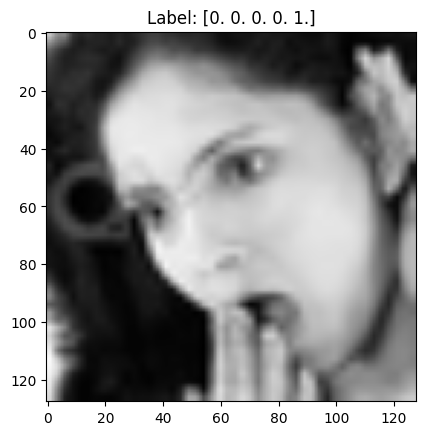

(1, 128, 128, 3)


In [23]:
# Print the same image after preprocessing
for image, label in train_ds.take(1):
    plt.imshow(image[0]*1/255)
    plt.title(f"Label: {label[0]}")
    plt.show()

# Print the shape of the images after preprocessing
for image, label in train_ds.take(1):
    print(image.shape)

In [24]:
# Get class names and the size of the data sets
train_size = train_ds.cardinality().numpy()
val_size = val_ds.cardinality().numpy()

train_ds = train_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.unbatch().batch(BATCH_SIZE)

# Repeat training data set to ensure enough data
train_ds = train_ds.repeat()

In [25]:
# Load the EfficientNetV2 model as the base model and freeze the weights
# Don't add top layer and add our own top

base_model = EfficientNetV2B3(input_shape=(model_pixels, model_pixels, 3),
                             include_top=False,
                             weights='imagenet',
                             pooling=None)

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 300

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


# Add layers on top of the base model
model = Sequential([base_model,
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dropout(0.2),
                    Dense(256, activation='relu'),
                    Dropout(0.2),
                    Dense(len(class_names), kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation='softmax')])

# Build the model
model.build((None,)+(model_pixels, model_pixels)+(3,))
model.summary()

Number of layers in the base model:  409
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 4, 4, 1536)        12930622  
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 24576)             0         
                                                                 
 dense_3 (Dense)             (None, 1024)              25166848  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
             

In [26]:
# Compile the model
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [27]:
steps_per_epoch = train_size // (BATCH_SIZE * 2)
validation_steps = val_size // BATCH_SIZE

print(steps_per_epoch)
print(train_size)

590
18897


In [28]:
# Train the model

# Implement early stopping with patience 3
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
# Put in fit function: callbacks=[early_stopping]

#with tf.device('/device:GPU:0'):
hist = model.fit(train_ds,
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds,
                    validation_steps=validation_steps).history

Epoch 1/10
590/590 [==============================] - 2037s 3s/step - loss: 1.2612 - accuracy: 0.5216 - val_loss: 1.0369 - val_accuracy: 0.5869
Epoch 2/10
590/590 [==============================] - 1351s 2s/step - loss: 1.0955 - accuracy: 0.5711 - val_loss: 0.9748 - val_accuracy: 0.6254
Epoch 3/10
590/590 [==============================] - 1021s 2s/step - loss: 0.9778 - accuracy: 0.6278 - val_loss: 1.0160 - val_accuracy: 0.6294
Epoch 4/10
590/590 [==============================] - 1020s 2s/step - loss: 0.9646 - accuracy: 0.6369 - val_loss: 0.9077 - val_accuracy: 0.6534
Epoch 5/10
590/590 [==============================] - 1007s 2s/step - loss: 0.8758 - accuracy: 0.6732 - val_loss: 0.9490 - val_accuracy: 0.6394
Epoch 6/10
590/590 [==============================] - 977s 2s/step - loss: 0.8765 - accuracy: 0.6715 - val_loss: 0.9207 - val_accuracy: 0.6686
Epoch 7/10
590/590 [==============================] - 1027s 2s/step - loss: 0.8013 - accuracy: 0.6984 - val_loss: 0.9287 - val_accuracy: 

In [29]:
import pandas as pd

hist_df = pd.DataFrame(hist)

hist_csv_file = 'smalldataset_incl_finetuning.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

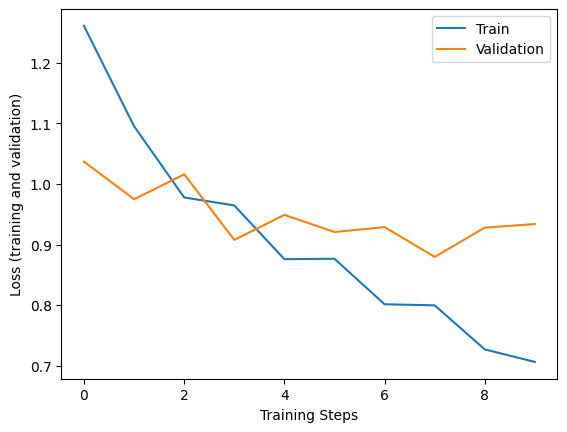

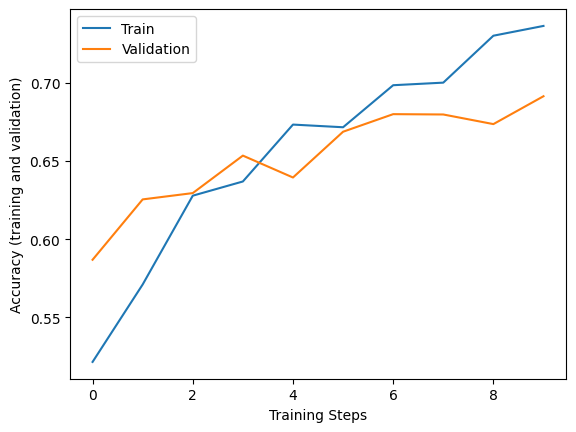

In [30]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.plot(hist["loss"], label='Train')
plt.plot(hist["val_loss"], label ='Validation')
plt.legend()

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.plot(hist["accuracy"], label='Train')
plt.plot(hist["val_accuracy"], label ='Validation')
plt.legend()

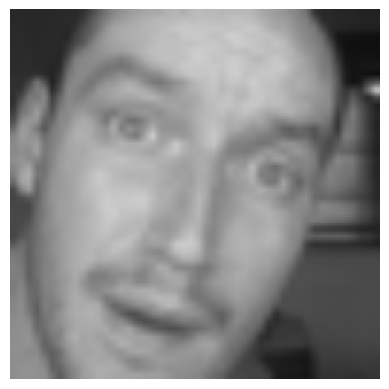

1/1 [==============================] - 6s 6s/step
True label: surprised
Predicted label: angry


In [31]:
x, y = next(iter(val_ds))
image = x[0, :, :, :] * 1 / 255
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

In [32]:
def build_testset():
    return image_dataset_from_directory(
                        f"drive/MyDrive/small_archive/test",
                        label_mode="categorical",
                        color_mode="grayscale",
                        image_size=IMAGE_SIZE,
                        batch_size=1,
                        seed=42,
                        shuffle=False)

In [34]:
# Build test set
test_ds = build_testset()

# Apply the preprocessing model to the test dataset
test_ds = test_ds.map(lambda x, y: (preprocessing_model(x), y))

# Get the test set size
test_size = test_ds.cardinality().numpy()

# Predict the labels of the test dataset
y_pred = model.predict(test_ds, verbose=1)

# Get the loss and accuracy of the model on the test dataset
loss, accuracy = model.evaluate(test_ds, verbose=1)

print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Found 6063 files belonging to 5 classes.
6063/6063 [==============================] - 476s 78ms/step - loss: 0.9048 - accuracy: 0.6973
Test loss: 0.904806911945343
Test accuracy: 0.6973445415496826


In [35]:
# Get the true labels of the test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

# Get the predicted labels
y_pred = np.argmax(y_pred, axis=1)

In [36]:
#Produce a cm across all classes
def plot_confusion_matrix(cm, class_names):
    figure, ax = plt.subplots(figsize=(5, 5))
    cm_norm = cm / tf.reduce_sum(cm, axis=1)[:, None]
    ax.imshow(cm_norm, interpolation='nearest', cmap=plt.get_cmap('Blues'), vmin=0, vmax=1)
    accuracy_ = np.trace(cm) / float(np.sum(cm))
    ax.set_title(f'Accuracy: {100*accuracy_:.2f}%', fontsize=14, fontweight='bold')
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(class_names)


    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, f'{cm_norm[i, j]:.2f}', ha='center', va='center', color='k')

    figure.tight_layout()
    plt.xlabel('Predicted', fontweight='bold', fontsize=14)
    plt.ylabel('True', fontweight='bold', fontsize=14)

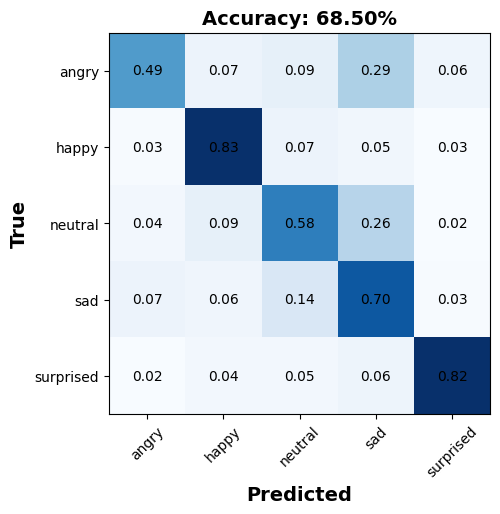

In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='true')

plot_confusion_matrix(cm, class_names)

In [38]:
# Find out if this method works for saving the model

model.save("efficientnet_v2_only5categories.keras")

1/1 [==============================] - 0s 136ms/step


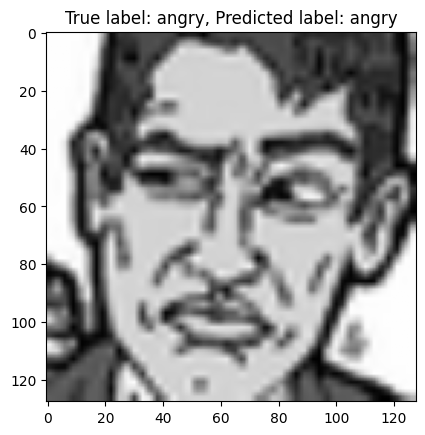

In [39]:
for image, label in test_ds.take(1):
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)
    plt.imshow(image[0]*1/255)
    plt.title(f"True label: {class_names[np.argmax(label[0])]}, Predicted label: {class_names[predicted_label[0]]}")
    plt.show()